# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Set Hyperparameters

In [2]:
INPUT_SHAPE = 784
INPUT_CLASSES = 10
BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

# Load Data

In [3]:
train_dataset = datasets.MNIST(root = "dataset/", train = True, transform = transforms.ToTensor(), download = True)
test_dataset = datasets.MNIST(root = "dataset/", train = False, transform = transforms.ToTensor(), download = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [4]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: dataset/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

# Create the Network

In [6]:
class SimpleNN(nn.Module) : 
  def __init__(self, input_size, n_classes) :
    super(SimpleNN, self).__init__()
    self.fc1 = nn.Linear(input_size, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, n_classes)
  
  def forward(self, x) : 
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [7]:
# TEST MODEL

T_INPUT_SHAPE = 784
T_INPUT_CLASSES = 10
T_BATCH_SIZE = 64

test_model = SimpleNN(T_INPUT_SHAPE, T_INPUT_CLASSES)
x = torch.randn(T_BATCH_SIZE, T_INPUT_SHAPE)
res = tuple(test_model(x).shape)
print(res)
assert res == (T_BATCH_SIZE, T_INPUT_CLASSES), "Model output shape wrong"

(64, 10)


# Set Device

In [8]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cpu


# Training

## Create Model Instance

In [9]:
model = SimpleNN(INPUT_SHAPE, INPUT_CLASSES).to(DEVICE)

## Loss Function and Optimizer

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

# Accuracy

In [11]:
def accuracy(scores, targets) :
  l = targets.numel() 
  corr = np.sum(np.argmax(scores.detach().numpy(), axis=1) == targets.numpy())
  return corr/l

# Train the netwrok

In [12]:
history = {
    "train_losses" : [],
    "test_losses" : [],
    "train_accuracy" : [],
    "test_accuracy" : []
}

for epoch in range(NUM_EPOCHS) :
  train_losses = []
  test_losses = [] 
  train_acc = []
  test_acc = []

  model.train()
  for data, targets in train_loader : 
    data = data.to(DEVICE)
    targets = targets.to(DEVICE)
    data = data.reshape(data.shape[0], -1)
    scores = model(data) # Get output
    loss = criterion(scores, targets) # Get loss
    optimizer.zero_grad() # Flush optimizer
    loss.backward() # Calculate gradients
    optimizer.step() # Gradient Descent
    train_losses.append(float(loss))
    train_acc.append(accuracy(scores, targets))

  model.eval()
  with torch.no_grad() :
      for t_data, t_targets in test_loader :
        t_data = t_data.to(DEVICE)
        t_targets = t_targets.to(DEVICE)
        t_data = t_data.reshape(t_data.shape[0], -1)
        t_scores = model(t_data) 
        t_loss = criterion(t_scores, t_targets)
        test_losses.append(float(t_loss))
        test_acc.append(accuracy(t_scores, t_targets))
  history["train_losses"].append(sum(train_losses)/len(train_losses))
  history["test_losses"].append(sum(test_losses)/len(test_losses))
  history["train_accuracy"].append(sum(train_acc)/len(train_acc))
  history["test_accuracy"].append(sum(test_acc)/len(test_acc))

# Plotting

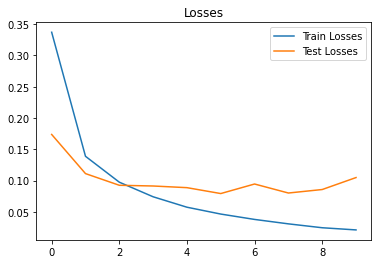

In [13]:
plt.title("Losses")
plt.plot(history["train_losses"], label="Train Losses")
plt.plot(history["test_losses"], label="Test Losses")
plt.legend()
plt.show()

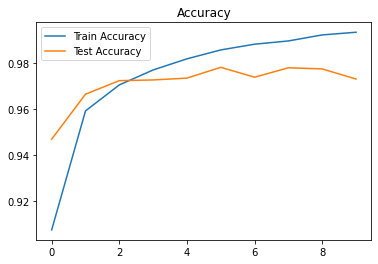

In [14]:
plt.title("Accuracy")
plt.plot(history["train_accuracy"], label="Train Accuracy")
plt.plot(history["test_accuracy"], label="Test Accuracy")
plt.legend()
plt.show()